# EMA-BBP-RSI Strategy for Taiwan Stock Market Day Trading

# Data Setup

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from tqdm.notebook import tqdm

In [2]:
data_filepath = 'data/data.feather'
data_df = pd.read_feather(data_filepath)
data_df.sort_index(ascending=True, inplace=True)

In [3]:
bbands_length = 20
bbands_std = 2.5
ema_length = 200
ema_volume_length = 20
rsi_length = 5

# Dictionary to collect computed results
results = {}

# Function to compute indicators for a given symbol
def compute_indicators(symbol):
    # Slice the dataframe once for the symbol
    df_symbol = data_df.xs(symbol, axis=1, level=1, drop_level=True)
    df_symbol = df_symbol.ffill()  # Fowardly fill the data with NaN between rows, to avoid discontinuity of ta calculation
    df_symbol['Value'] = df_symbol['Volume'] * df_symbol['Close']

    # Calculate returns
    adj_close = df_symbol['Adj Close']
    open_price = df_symbol['Open']
    close = df_symbol['Close']
    adj_open = (open_price / close) * adj_close
    rtns = 100 * (adj_close - adj_open) / adj_open
    targets = 100 * (adj_close - adj_close.shift(1)) / adj_close.shift(1)
    gap = 100 * (adj_open - adj_close.shift(1)) / adj_close.shift(1)
    
    # Compute TAs
    rsi= df_symbol.ta.rsi(length=rsi_length)
    results[(f'i_RSI_{rsi_length}', symbol)] = rsi
    
    ema = df_symbol.ta.ema(length=ema_length)
    results[(f'i_EMA_{ema_length}', symbol)] = ema

    bbands = df_symbol.ta.bbands(length=bbands_length, std=bbands_std)
    results[(f'i_BBP_{bbands_length}_{bbands_std}', symbol)] = bbands[f'BBP_{bbands_length}_{bbands_std}']

    ema_volume = df_symbol.ta.ema(close='Volume', length=ema_volume_length)
    results[(f'i_EMA_Volume_{ema_volume_length}', symbol)] = ema_volume
    results[(f'i_EMA_Volume_{ema_volume_length}_lag1', symbol)] = ema_volume.shift(1)

    ema_value = df_symbol.ta.ema(close='Value', length=ema_volume_length)
    results[(f'i_EMA_Value_{ema_volume_length}', symbol)] = ema_value
    results[(f'i_EMA_Value_{ema_volume_length}_lag1', symbol)] = ema_value.shift(1)

    # Update the results
    results[(f"returns", symbol)] = rtns
    results[(f"targets", symbol)] = targets
    results[(f"gap", symbol)] = gap

symbols = data_df.columns.get_level_values(1).unique()

for s in tqdm(symbols):
    compute_indicators(s)

  0%|          | 0/1786 [00:00<?, ?it/s]

In [4]:
# Concatenate the original DataFrame with the computed results
data_df = pd.concat([data_df, pd.DataFrame(results)], axis=1)

In [5]:
data_df.xs('6570.TWO', axis=1, level=1).tail()  # Inspect the result

,Adj Close,Close,High,Low,Open,Volume,i_RSI_5,i_EMA_200,i_BBP_20_2.5,i_EMA_Volume_20,i_EMA_Volume_20_lag1,i_EMA_Value_20,i_EMA_Value_20_lag1,returns,targets,gap
Date,,,,,,,,,,,,,,,,
2023-11-10,49.650002,49.650002,50.700001,49.400002,50.500000,272000.0,28.096283,57.234294,0.227371,132316.597518,117613.081467,6.957304e+06,6.268094e+06,-1.683165,-2.071004,-0.394479
2023-11-13,49.599998,49.599998,49.799999,49.000000,49.700001,176000.0,27.425882,57.158331,0.225956,136476.921564,132316.597518,7.126094e+06,6.957304e+06,-0.201212,-0.100711,0.100703
2023-11-14,50.299999,50.299999,50.299999,49.599998,49.599998,35000.0,48.802776,57.090089,0.381930,126812.452843,136476.921564,6.615085e+06,7.126094e+06,1.411292,1.411292,0.000000
2023-11-15,50.400002,50.400002,50.799999,50.299999,50.299999,110000.0,51.361169,57.023521,0.423774,125211.266858,126812.452843,6.513077e+06,6.615085e+06,0.198812,0.198812,0.000000
2023-11-16,50.500000,50.500000,50.700001,50.299999,50.299999,47971.0,54.220631,56.958610,0.470299,117855.050967,125211.266858,6.123502e+06,6.513077e+06,0.397616,0.198410,-0.198417


In [6]:
data_df = data_df.iloc[-1260:]

# Trading Strategy

In [7]:
# Dictionary to collect computed results
results = {}

def gen_strategy_signals(symbol):
    df_symbol = data_df.xs(symbol, axis=1, level=1, drop_level=True)

    # Obtain the necessary series from df_symbol
    high = df_symbol['High']
    low = df_symbol['Low']
    ema = df_symbol[f'i_EMA_{ema_length}']
    bbp = df_symbol[f'i_BBP_{bbands_length}_{bbands_std:0.1f}']
    rsi = df_symbol[f'i_RSI_{rsi_length}']

    # Check for NaN values in any of the series
    nan_mask = high.isna() | low.isna() | ema.isna() | bbp.isna() | rsi.isna()

    # Initialize signal series with zeros
    signal_series = pd.Series(np.zeros(len(df_symbol)), index=df_symbol.index)

    # Evaluate long conditions
    long_conditions = (low > ema) & (bbp < 1) & (rsi < 30)
    signal_series = signal_series.where(~long_conditions, 1)

    # Evaluate short conditions
    short_conditions = (high < ema) & (bbp > 0) & (rsi > 50)
    signal_series = signal_series.where(~short_conditions, -1)  

    # Set signals to 0 where any NaN value is present
    signal_series[nan_mask] = 0

    # Update the results
    results[(f"signal", symbol)] = signal_series.shift(1)

# Proceed signal marking
symbols = data_df.columns.get_level_values(1).unique()

for s in tqdm(symbols):
    gen_strategy_signals(s)

  0%|          | 0/1786 [00:00<?, ?it/s]

In [8]:
# Concatenate the original DataFrame with the computed results
data_df = pd.concat([data_df, pd.DataFrame(results)], axis=1)

# Stock Selection

## Split and filter the data

In [9]:
def data_filtering(train, test, valid):
    train_close = train['Close']
    train_volume = train['Volume']
    symbols = train_close.columns
    
    symbols_to_remove = []
    
    for symbol in symbols:
        if train_close[symbol].isna().sum() > 252:
            symbols_to_remove.append(symbol)

    # filter the dfs
    filtered_train = train.drop(columns=symbols_to_remove, level=1)
    filtered_test = test.drop(columns=symbols_to_remove, level=1)
    filtered_valid = valid.drop(columns=symbols_to_remove, level=1)

    return filtered_train, filtered_test, filtered_valid 

# Split data_df into training and testing sets
train_size = int(len(data_df) * 0.8)
train_df = data_df.iloc[:train_size].copy()
test_df = data_df.iloc[train_size:].copy()

train_size = int(len(train_df) * 0.9)
valid_df = train_df.iloc[train_size:].copy()
train_df = train_df.iloc[:train_size].copy()

# Apply the data_filtering function
filtered_train_df, filtered_test_df, filtered_valid_df = data_filtering(train_df, test_df, valid_df)

## Refine the stock list

In [10]:
selected_symbols = filtered_train_df.columns.get_level_values(1).unique()
df_index = filtered_train_df.index

In [11]:
# Dictionary to store the results
stats_results = {}

for symbol in selected_symbols:
    # Extract features and target for the current stock
    stock_data = data_df.xs(symbol, axis=1, level=1).loc[df_index].copy()

    # Calculate mean and stdev
    long_df = stock_data.loc[stock_data['signal'] == 1, 'targets']
    mean_long = long_df.mean()
    stdev_long = long_df.std()
    
    short_df = stock_data.loc[stock_data['signal'] == -1, 'targets']
    mean_short = short_df.mean()
    stdev_short = short_df.std()

    avg_volume = stock_data.loc[stock_data.index[-1], f'i_EMA_Volume_{ema_volume_length}'] / 1000
    
    # Store the results in the dictionary
    stats_results[symbol] = {
        'mean_long': mean_long,
        'stdev_long': stdev_long,
        'mean_short': mean_short,
        'stdev_short': stdev_short,
        'ratio_long': (mean_long / stdev_long) * avg_volume if len(long_df.index) >= 20 else np.nan,
        'ratio_short': (mean_short / stdev_short) * avg_volume if len(short_df.index) >= 20 else np.nan,
    }

# Convert the results dictionary to a DataFrame for better visualization
stats_df = pd.DataFrame(stats_results).T

# Backtest

## Apply stock selection

In [12]:
percentile_threshold = 80

long_ratio_values = [item['ratio_long'] for item in stats_results.values() if not np.isnan(item['ratio_long'])]
short_ratio_values = [item['ratio_short'] for item in stats_results.values() if not np.isnan(item['ratio_short'])]

top_percentile_long = max(0, np.percentile(long_ratio_values, percentile_threshold)) if len(long_ratio_values) > 0 else np.nan
top_percentile_short = min(0, np.percentile(short_ratio_values, (100 - percentile_threshold))) if len(short_ratio_values) > 0 else np.nan

refined_selected_symbols = [s for s in selected_symbols \
                            if stats_results[s]['ratio_long'] > top_percentile_long or stats_results[s]['ratio_short'] < top_percentile_short]

# Sort the list to prioritize high expected value symbols
refined_selected_symbols = sorted(
    refined_selected_symbols,
    key=lambda symbol: (
        max(0, stats_results[symbol]['mean_long']) + max(0, -stats_results[symbol]['mean_short'])
    ),
    reverse=True,
)

print(f'Size of the refined selected symbols: {len(refined_selected_symbols)}')

Size of the refined selected symbols: 596


## Doing test

In [33]:
# The df use for the test
df = pd.concat([filtered_valid_df, filtered_test_df])

# Initial conditions and parameters
initial_capital = 200000
equity = initial_capital
fund_available = equity
fund_available_list = []
equity_curve = [initial_capital]
return_list = []
pnl_list = []
positions = {}  # Dictionary to track current positions
commission_rate = 0.002  # 0.2%

total_trade_value = 0
total_trade_count = 0
trade_value_list = []
position_value_list = []
position_share_list = []

last_day_trade_list = []

In [34]:
for date in tqdm(df.index):

    pnl = 0
    fund_available = min(equity_curve[-1] * 5, initial_capital * 5)  # Round-trip value limit: 10x capital
    position_sizing = 0.1
    residual_position_sizing = 0.2

    trade_value_list.append(0)

    # Get monitoring list
    long_list = []
    short_list = []
    priority_list = []
    
    # Get potential symbols to trade
    for symbol in refined_selected_symbols:
        stock_data = df.xs(symbol, axis=1, level=1).loc[date]
    
        match stock_data['signal']:
            case 1:
                long_list.append(symbol)
                priority_list.append(symbol)
                
            case -1:
                short_list.append(symbol)
                priority_list.append(symbol)
                
            case _:
                pass
        
    # Loop through each stock
    for symbol in refined_selected_symbols:
         # Get stock data
        stock_data = df.xs(symbol, axis=1, level=1).loc[date]
        
        if any(np.isnan(x) for x in [stock_data['Open'], stock_data['Close'], stock_data['Adj Close'], stock_data['signal'], stock_data['Volume']]):  # Check if data is available
            continue

        close = stock_data['Close']
        open = stock_data['Open']
        adj_close = close # stock_data['Adj Close']
        adj_open = open # open * adj_close / close
        volume = stock_data['Volume']
        volume_ema_lag = stock_data[f'i_EMA_Volume_{ema_volume_length}_lag1']
        action = stock_data['signal']

        # Trade volume filter
        if np.isnan(volume_ema_lag) or (volume_ema_lag // 1000) < 100:
            continue

        # Position sizing adkustment
        try:
            if abs(action) > 0:
                position = priority_list.index(symbol)
                relative_pos = position / len(priority_list)
    
                if relative_pos < 0.1:
                    position_sizing = 0.2
                elif relative_pos < 0.4:
                    position_sizing = 0.15
        
        except ValueError:
            print(f"'{symbol}' is not in the list.")
            break
        
        # Execute action
        if abs(action) > 0:
            trade_filter = ( stock_data['gap'] < -2 ) if action == 1 else ( 2 < stock_data['gap'] )
            if trade_filter:        
                trade_side = action
                price = adj_open
                
                equity_adj = equity_curve[-1] / 1000  # 整張操作調整
                fund_available_adj = fund_available / 1000  # 整張操作調整
                
                num_shares = int(equity_adj * position_sizing * (1 - commission_rate) / price)
                num_shares_max = int(fund_available_adj * residual_position_sizing * (1 - commission_rate) / price)
                num_shares = num_shares_max if num_shares > num_shares_max else num_shares

                # 交易量擬真調整
                num_share_volume_upper_bound = int((volume / 1000) / 10)
                if num_shares > num_share_volume_upper_bound:
                    num_shares = num_share_volume_upper_bound
                
                num_shares_adj = num_shares * 1000  # 整張操作調整
                
                if num_shares_adj > 0:
                    trade_value = num_shares_adj * price
                    total_trade_value += num_shares_adj * open
                    pnl -= trade_side * trade_value * (1 + trade_side * commission_rate)
                    fund_available -= trade_value * (1 + commission_rate)
                    positions[symbol] = {'action': action, 'num_shares': num_shares_adj, 'entry_date': date, 'entry_pruice': price}

                    position_value_list.append(num_shares_adj * open)
                    position_share_list.append(num_shares_adj)
        
        # Close position (if any)
        if symbol in positions:
            days_held = (date - positions[symbol]['entry_date']).days
            if days_held >= 0:
                trade_side = -1 if positions[symbol]['action'] == 1 else 1
                num_shares = positions[symbol]['num_shares']
                trade_value = num_shares * adj_close
                total_trade_value += num_shares * close
                pnl -= trade_side * trade_value * (1 + trade_side * commission_rate)
                del positions[symbol]  # Remove position
                total_trade_count += 1

            # Store the last day trading information
            if date == df.index[-1]:
                trade_detail = {
                    'symbol': symbol,
                    'action': action,
                    'share_traded': num_shares,
                    'value_traded': num_shares * open,
                    'pnl_percent': ((close - open) / open) * action
                }
                
                last_day_trade_list.append(trade_detail)
                
    # Calculate equity and daily return
    equity = equity_curve[-1] + pnl
    daily_return = (equity - equity_curve[-1]) / equity_curve[-1]
    pnl_list.append(pnl)
    fund_available_list.append(fund_available)
    return_list.append(daily_return)
    equity_curve.append(equity)

  0%|          | 0/353 [00:00<?, ?it/s]

## Performance metrics and statistics

In [35]:
# Calculate performance metrics
final_equity = equity_curve[-1]
total_return = (final_equity - initial_capital) / initial_capital
annualized_return = (1 + total_return) ** (252 / len(df.index)) - 1
annualized_sharpe_ratio = np.sqrt(252) * np.mean(return_list) / np.std(return_list)
profit_factor = sum([x for x in pnl_list if x > 0]) / abs(sum([x for x in pnl_list if x < 0]))
win_day_ratio = 100 * len([x for x in pnl_list if x > 0]) / len(pnl_list)

# Print performance metrics
print(f"Period: {df.index[0].date()} - {df.index[-1].date()}, {len(df.index)} trading days")
print(f"Initial Equity: ${initial_capital:.0f}")
print(f"Final Equity: ${final_equity:.0f}")
print(f"Total Rate of Return: {total_return * 100:.2f}%")
print(f"Annualized Rate of Return: {annualized_return * 100:.2f}%")
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Total Trade Count: {total_trade_count}")
print(f"Avg. Daily Trade Count: {total_trade_count / len(df.index) :.2f}")
print(f"Average PnL Percent: {100 * np.mean([p / e for p, e in zip(pnl_list, equity_curve[:-1])]):.2f}%")
print(f"Median PnL Percent: {100 * np.median([p / e for p, e in zip(pnl_list, equity_curve[:-1])]):.2f}%")
print(f"PnL Percent Stdev: {100 * np.std([p / e for p, e in zip(pnl_list, equity_curve[:-1])]):.2f}%")
print(f"Avg. PnL: {np.mean(pnl_list):.2f}")
print(f"Median PnL: {np.median(pnl_list):.2f}")
print(f"Max PnL: {np.max(pnl_list):.2f}")
print(f"Min PnL: {np.min(pnl_list):.2f}")
print(f"Win Day Ratio: {win_day_ratio:.2f}%")

Period: 2022-06-09 - 2023-11-16, 353 trading days
Initial Equity: $200000
Final Equity: $270853
Total Rate of Return: 35.43%
Annualized Rate of Return: 24.17%
Annualized Sharpe Ratio: 1.87
Profit Factor: 1.72
Total Trade Count: 509
Avg. Daily Trade Count: 1.44
Average PnL Percent: 0.09%
Median PnL Percent: 0.00%
PnL Percent Stdev: 0.75%
Avg. PnL: 200.72
Median PnL: 0.00
Max PnL: 22295.59
Min PnL: -5051.50
Win Day Ratio: 32.86%


In [36]:
monthly_trade_value = (total_trade_value / len(df.index)) * (252 / 12)

print(f"Monthly Average Trade Value: {monthly_trade_value:.2f}")
print(f"Monthly Turnover Ratio Est.: {monthly_trade_value / ((initial_capital+final_equity) / 2):.2f}")

Monthly Average Trade Value: 1719469.42
Monthly Turnover Ratio Est.: 7.30


In [37]:
print(f'Median Position Size: {np.median(position_value_list):.2f}')
print(f'Max Position Size: {np.max(position_value_list):.2f}')
print(f'Min Position Size: {np.min(position_value_list):.2f}')
print(f'Median Position Share: {np.median(position_share_list):.2f}')
print(f'Max Position Share: {np.max(position_share_list):.2f}')
print(f'Min Position Share: {np.min(position_share_list):.2f}')
print(f'Error Check: {np.sum([x % 1000 for x in position_share_list]):.2f}')

Median Position Size: 28400.00
Max Position Size: 51700.00
Min Position Size: 11600.00
Median Position Share: 1000.00
Max Position Share: 10000.00
Min Position Share: 1000.00
Error Check: 0.00


## Visualization & Benchmark

### Metric function

In [38]:
import numpy as np

def information_ratio(strategy_returns, benchmark_returns):
    if len(strategy_returns) != len(benchmark_returns):
        print(f'strategy len {len(strategy_returns)}, benchmark len {len(benchmark_returns)}')
        raise ValueError("Strategy returns and benchmark returns must be of the same length")
    
    strategy_returns = np.array(strategy_returns)
    benchmark_returns = np.array(benchmark_returns)
    
    active_returns = strategy_returns - benchmark_returns
    tracking_error = np.std(active_returns)
    
    if tracking_error == 0:
        return np.nan
    
    information_ratio = np.mean(active_returns) / tracking_error
    return information_ratio

In [39]:
benchmark_last_day_returns = {}

### Benchmark 1: TSEC Weighted Index

In [20]:
import yfinance as yf

# Load benchmark
index_df = yf.download(['^TWII'], start=df.index[0], end=df.index[-1], progress=True)

[*********************100%%**********************]  1 of 1 completed


In [40]:
import statsmodels.api as sm

strategy_returns = return_list[1:]
benchmark_returns = index_df['Adj Close'].pct_change().fillna(0)

benchmark_last_day_returns['TSEC'] = benchmark_returns.iloc[-1]

# Information Ratio
ir_annulized = information_ratio(strategy_returns, benchmark_returns) * np.sqrt(252)

# Alpha & Beta
X = np.array(benchmark_returns).reshape(-1, 1)
y = np.array(strategy_returns).reshape(-1, 1)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
alpha, beta = model.params
annual_alpha = alpha * 252
alpha_pvalue = model.pvalues[0]

print(f'Information Ratio (Annualized): {ir_annulized:0.4f}')
print(f'Alpha (Annualized): {annual_alpha:0.4f} (p-value {alpha_pvalue:0.4f})')
print(f'Beta: {beta:0.4f}')

Information Ratio (Annualized): 0.7241
Alpha (Annualized): 0.2256 (p-value 0.0273)
Beta: -0.0250


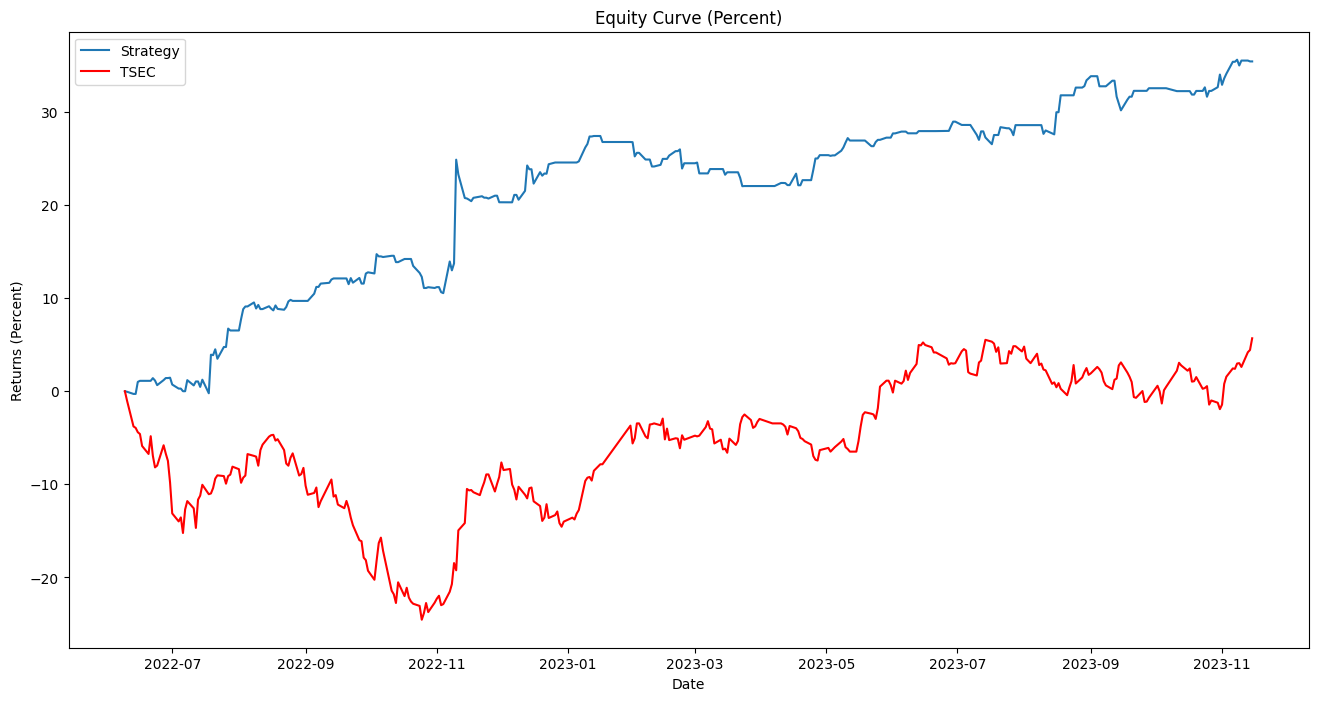

In [41]:
import matplotlib.pyplot as plt

# Plot equity curve
plt.figure(figsize=(16, 8))
plt.plot(df.index[:-1], [((x / initial_capital) - 1) * 100 for x in equity_curve[2:]], label="Strategy")
plt.plot(index_df.index, [x * 100 for x in (index_df['Adj Close'] / index_df['Adj Close'].iloc[0] - 1)], label="TSEC", color='red')
plt.title('Equity Curve (Percent)')
plt.xlabel('Date')
plt.ylabel('Returns (Percent)')
plt.legend(loc='upper left')
plt.show()

### Benchmark 2: 0050

In [23]:
import yfinance as yf

# Load benchmark
index_df = yf.download(['0050.TW'], start=df.index[0], end=df.index[-1], progress=True)

[*********************100%%**********************]  1 of 1 completed


In [24]:
import statsmodels.api as sm

strategy_returns = return_list[1:]
benchmark_returns = index_df['Adj Close'].pct_change().fillna(0)

benchmark_last_day_returns['0050'] = benchmark_returns.iloc[-1]

# Information Ratio
ir_annulized = information_ratio(strategy_returns, benchmark_returns) * np.sqrt(252)

# Alpha & Beta
X = np.array(benchmark_returns).reshape(-1, 1)
y = np.array(strategy_returns).reshape(-1, 1)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
alpha, beta = model.params
annual_alpha = alpha * 252
alpha_pvalue = model.pvalues[0]

print(f'Information Ratio (Annualized): {ir_annulized:0.4f}')
print(f'Alpha (Annualized): {annual_alpha:0.4f} (p-value {alpha_pvalue:0.4f})')
print(f'Beta: {beta:0.4f}')

Information Ratio (Annualized): 0.7241
Alpha (Annualized): 0.2256 (p-value 0.0273)
Beta: -0.0250


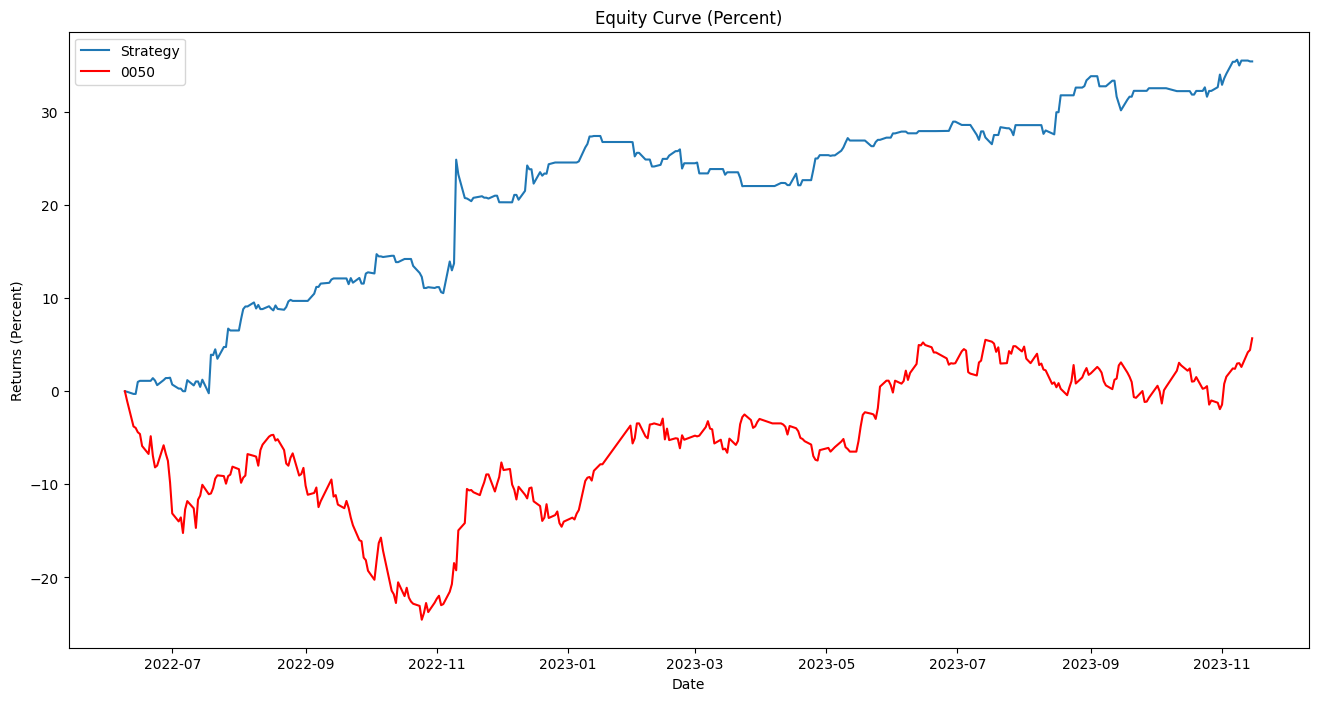

In [25]:
import matplotlib.pyplot as plt

# Plot equity curve
plt.figure(figsize=(16, 8))
plt.plot(df.index[:-1], [((x / initial_capital) - 1) * 100 for x in equity_curve[2:]], label="Strategy")
plt.plot(index_df.index, [x * 100 for x in (index_df['Adj Close'] / index_df['Adj Close'].iloc[0] - 1)], label="0050", color='red')
plt.title('Equity Curve (Percent)')
plt.xlabel('Date')
plt.ylabel('Returns (Percent)')
plt.legend(loc='upper left')
plt.show()

# Store the daily results

In [26]:
import os
import json
import builtins

daily_results_file_path = 'results/daily_results_EMA_BBP_RSI.json'

In [27]:
daily_results = []

if os.path.exists(daily_results_file_path):
    # Load from JSON file
    with builtins.open(daily_results_file_path, 'r', encoding='utf-8') as f:
        daily_results = json.load(f)  # Load from JSON file

In [28]:
# The result of today
result_today = {
    'date': df.index[-1].date(),
    'trade_list': last_day_trade_list,
    'period_start_equity': equity_curve[-2],
    'period_end_equity': equity_curve[-1],
    'daily_return_strategy': (equity_curve[-1] - equity_curve[-2]) / equity_curve[-2],
    'daily_return_bechmark_TSEC': benchmark_last_day_returns['TSEC'],
    'daily_return_bechmark_0050': benchmark_last_day_returns['0050'],
}

In [29]:
from datetime import datetime, timedelta, timezone

# Convert the current UTC time to UTC+8 timezone
now_utc8 = datetime.now(timezone(timedelta(hours=8)))

# Check if the current time is after 3 PM UTC+8
if now_utc8.hour >= 15:
    # Check if the last date in df is the same as today's date
    if df.index[-1].date() == now_utc8.date():
        # Check if daily_results does not have any element with 'date' the same as 'date' of result_today
        if not daily_results or (not any(datetime.strptime(result['date'], '%Y-%m-%d').date() == result_today['date'] for result in daily_results)):
            daily_results.append(result_today)
            print('daily_results updated!')

In [30]:
# Save to JSON file
# with builtins.open(daily_results_file_path, 'w', encoding='utf-8') as f:
#     json.dump(daily_results, f, default=str, ensure_ascii=False, indent=4)

In [31]:
daily_results

[{'date': '2023-11-01',
  'trade_list': [{'symbol': '6240.TWO',
    'action': -1.0,
    'share_traded': 1000,
    'value_traded': 19700.000762939453,
    'pnl_percent': 0.01269035483847856},
   {'symbol': '9949.TWO',
    'action': -1.0,
    'share_traded': 4000,
    'value_traded': 59400.001525878906,
    'pnl_percent': 0.03367003280511123},
   {'symbol': '6415.TW',
    'action': -1.0,
    'share_traded': 1000,
    'value_traded': 295500.0,
    'pnl_percent': -0.015228426395939087},
   {'symbol': '1760.TW',
    'action': -1.0,
    'share_traded': 2000,
    'value_traded': 231000.0,
    'pnl_percent': 0.012987012987012988},
   {'symbol': '3105.TWO',
    'action': -1.0,
    'share_traded': 1000,
    'value_traded': 148000.0,
    'pnl_percent': 0.006756756756756757},
   {'symbol': '2024.TW',
    'action': 1.0,
    'share_traded': 1000,
    'value_traded': 18899.999618530273,
    'pnl_percent': 0.021164001407603137}],
  'period_start_equity': 1420216.5742664337,
  'period_end_equity': 1419

# Print potential stocks to trade for the next day

In [42]:
long_list = []
short_list = []
priority_list = []

# Symbols for tomorrow
for symbol in refined_selected_symbols:
    stock_data = df.xs(symbol, axis=1, level=1).loc[df.index[-1]]

    # Trade volume filter
    volume_ema_lag = stock_data[f'i_EMA_Volume_{ema_volume_length}_lag1']
    if np.isnan(volume_ema_lag) or (volume_ema_lag // 1000) < 100:
        continue

    match stock_data['signal']:
        case 1:
            long_list.append(symbol)
            priority_list.append(symbol)
            
        case -1:
            short_list.append(symbol)
            priority_list.append(symbol)
            
        case _:
            pass

# Show the result
print(f'做多監控個股 ({len(long_list)} 檔): {long_list}\n')
print(f'做空監控個股 ({len(short_list)} 檔): {short_list}\n')
print(f'優先順序: {priority_list}')

做多監控個股 (9 檔): ['5348.TWO', '6419.TWO', '4542.TWO', '4747.TWO', '4105.TWO', '2063.TWO', '4706.TWO', '3702.TW', '8048.TWO']

做空監控個股 (121 檔): ['2637.TW', '2017.TW', '1467.TW', '3037.TW', '1905.TW', '2014.TW', '4739.TW', '8046.TW', '1440.TW', '8255.TWO', '8069.TWO', '6457.TWO', '1802.TW', '3535.TW', '3481.TW', '1611.TW', '2009.TW', '3504.TW', '3209.TW', '8415.TWO', '2351.TW', '6269.TW', '2038.TW', '6015.TWO', '8261.TW', '6278.TW', '1312.TW', '8478.TW', '2328.TW', '5299.TWO', '1760.TW', '5425.TWO', '5285.TW', '6441.TWO', '6202.TW', '8906.TWO', '6217.TWO', '8028.TW', '8183.TWO', '3576.TW', '3207.TWO', '2428.TW', '6129.TWO', '4952.TW', '6164.TW', '2337.TW', '6245.TWO', '2615.TW', '3455.TWO', '6116.TW', '4931.TWO', '1434.TW', '2409.TW', '3707.TWO', '9945.TW', '8420.TWO', '2102.TW', '4736.TWO', '1304.TW', '4142.TW', '1308.TW', '1301.TW', '2308.TW', '4721.TWO', '6509.TWO', '2618.TW', '5014.TWO', '3047.TW', '3003.TW', '5309.TWO', '2608.TW', '2641.TWO', '5009.TWO', '2406.TW', '1409.TW', '8938.TWO'